In [0]:
import cv2
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy import ndimage
import time

import keras
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import ResNet50, InceptionV3, inception_v3, resnet50, mobilenet_v2, MobileNetV2
from keras.preprocessing import image
# from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam, RMSprop
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras import backend as K

import random
import cv2
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


* load model

In [0]:
filepath="drive/My Drive/MSc dataset/food5k/Food-5K/models/resnet50_last_6_256.best.hdf5"
model = load_model(filepath)

W0819 22:57:33.644901 139673368418176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0819 22:57:33.733661 139673368418176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0819 22:57:33.794085 139673368418176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0819 22:57:33.798139 139673368418176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0819 22:57:33.79981

* Related processing functions

In [0]:
def get_intermediate_results(model):
    last_conv_activation_layer = model.layers[-3]
    final_dense = model.layers[-1]
    weights = final_dense.get_weights()[0]
    #print(f'weigths shape: {weights.shape}')
    conv_out_func = K.function([model.input], [last_conv_activation_layer.output])
    return weights, conv_out_func

def visualizeCAM(img_path, weights, conv_out_func, preprocess_func, class_index, return_cam=False, visualize=True, input_shape=(256, 256), save=False):
    img = image.load_img(img_path) # height, width, channel
    img = image.img_to_array(img)
    #img = cv2.imread(img_path) 
    ori_img = img.copy()
    #print(ori_img.shape)
    img = cv2.resize(img, input_shape)
    # preprocess the image
    x = np.expand_dims(img, axis=0)
    x = preprocess_func(x)
    # prediction
    #pred = model.predict(x)[0]
    #print(f'Prediction: {pred}')
    conv_out = conv_out_func([x])[0][0]
    #print(f'conv shape: {conv_out.shape}')  # validate the shape
    # create heap map
    cam = returnCAM(conv_out, weights, class_index)
    # resize: (width, height)
    cam = cv2.resize(cam, (ori_img.shape[1], ori_img.shape[0]))
    #print('Resized cam shape:', cam.shape)
    if visualize:
        heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        result = heatmap * 0.6 + ori_img * 0.4
        #plt.figure(figsize=(20,10))
        plt.imshow(result / 255)
        plt.axis('off')  # remove axis
        if save:
            plt.savefig("cam.png", bbox_inches='tight')  # save the image
        plt.show()
        #cv2.imwrite('CAM.jpg', result)
    if return_cam:
        return cam
    

def returnCAM(feature_conv, weight_softmax, class_idx):
    # feature_conv : width * height * channel
    cam = feature_conv.dot(weight_softmax[:, class_idx])
    #Create the class activation map.
    #print('np min:', np.min(cam))
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    cam_img = np.uint8(255 * cam_img)
    #output_cam = cv2.resize(cam_img, (256, 256))
    #print(f'output cam shape: {output_cam.shape}')
    return cam_img


def find_bounding_boxes(labeled, num_of_objects, shape=(256, 256)):
    max_h, max_w = shape
    rows, cols = labeled.shape
    
    bboxes = np.zeros([num_of_objects, 4])
    top, left, bottom, right = max_h, max_w, 0, 0
    
    for i in range(num_of_objects):
        bboxes[i] = left, top, right, bottom
    
    for r in range(rows):
        for c in range(cols):
            if (labeled[r][c] != 0):
                idx = labeled[r][c] - 1;
                # top
                if (r < bboxes[idx][1]):
                    bboxes[idx][1] = r
                # left
                if (c < bboxes[idx][0]):
                    bboxes[idx][0] = c
                # bottom
                if (r > bboxes[idx][3]):
                    bboxes[idx][3] = r
                # right
                if (c > bboxes[idx][2]):
                    bboxes[idx][2] = c
                    
    return bboxes.astype(int)


def draw_bboxes(bboxes, img_path, save=False, print_max=False, gt=False):
    img = image.load_img(img_path)
    img = image.img_to_array(img)
    #print(img.shape)
    if print_max:
        # only draw the largest predicted bounding box
        max_area = 0
        max_box = None
        for box in bboxes:
            temp = (box[2] - box[0]) * (box[3] - box[1])
            if temp > max_area:
                max_area = temp
                max_box = box
        cv2.rectangle(img, (max_box[0], max_box[1]), (max_box[2], max_box[3]),(0,255,10), 2)
    else:
        for box in bboxes:
            #print(box)
            cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]),(0,255,10), 2)
    
    plt.axis('off')  # remove axis
    if save:
        #plt.figure(figsize=(20,10))
        if gt:
            filename = 'gt_box.png'
        else:
            filename = 'bbox.png'
        plt.imshow(img / 255)
        plt.savefig(filename, bbox_inches='tight')  # save the image
    else:
        plt.imshow(img / 255)

### Class Activation Mapping

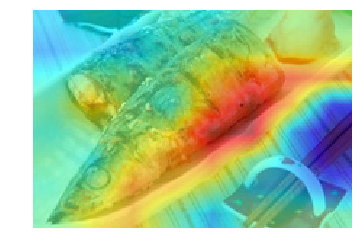

In [0]:
index = 4798
img_path = 'drive/My Drive/MSc dataset/localisation-test/mixed/%s.jpg' % str(index)
weights, conv_out_func = get_intermediate_results(model)
cam = visualizeCAM(img_path, weights, conv_out_func, resnet50.preprocess_input, 0, return_cam=True, visualize=True, save=False)

### Segmentation

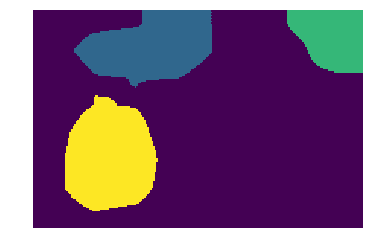

In [0]:
thresh = 0.5
threshold = thresh * np.max(cam)
# find connected components
labeled, num_of_objects = ndimage.label(cam > threshold) 
# visualize
#plt.figure(figsize=(20,10))
plt.imshow(labeled)
plt.axis('off')  # remove axis
# plt.savefig("segmentation.png", bbox_inches='tight')  # save the image
plt.show()

### Draw bounding boxes

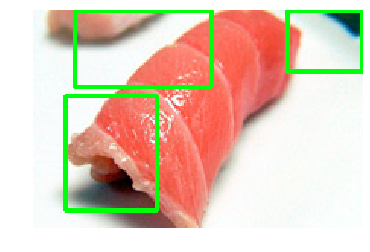

In [0]:
bboxes = find_bounding_boxes(labeled, num_of_objects)
draw_bboxes(bboxes, img_path, save=True)

### Ground truth

In [0]:
info = "drive/My Drive/MSc dataset/localisation-test/mixed/bb_info.txt"
bbox_info = pd.read_csv(info, sep=" ", index_col=0)

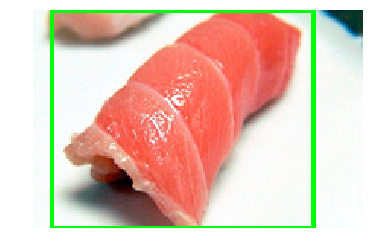

In [0]:
# 2699, 1409, 406
#index = 406
gt_box = np.array([bbox_info.loc[index]])
img_path = 'drive/My Drive/MSc dataset/localisation-test/mixed/%s.jpg' % str(index)
draw_bboxes(gt_box, img_path, save=True, gt=True)

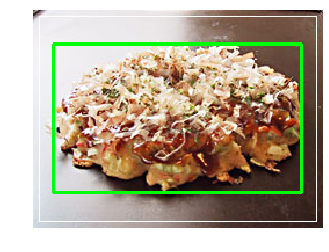

In [0]:
img_path = 'drive/My Drive/MSc dataset/localisation-test/mixed/%s.jpg' % str(index)
draw_bboxes(gt_box, img_path, save=False)

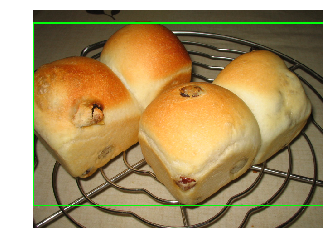

In [0]:
img_path = 'drive/My Drive/MSc dataset/localisation-test/mixed/%s.jpg' % str(index)
draw_bboxes(gt_box, img_path, save=False)

### Baseline model visualisation

In [0]:
import gluoncv
from gluoncv import model_zoo, data, utils

In [0]:
! pip install mxnet
! pip install gluoncv

     |████████████████████████████████| 25.4MB 2.8MB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 348kB 2.7MB/s 


In [0]:
yolo = model_zoo.get_model('yolo3_darknet53_voc', pretrained=True)
rcnn = model_zoo.get_model('faster_rcnn_resnet50_v1b_voc', pretrained=True)

Model file is not found. Downloading.


223070KB [00:07, 29783.20KB/s]                            


Model file is not found. Downloading.


121888KB [00:04, 27523.51KB/s]                            


In [0]:
def predict(model, img_path, flag):
    if flag == 'yolo':
        x, img = data.transforms.presets.yolo.load_test(img_path)
    elif flag == 'rcnn':
        x, img = data.transforms.presets.rcnn.load_test(img_path)
    print('Shape of pre-processed image:', x.shape)
    class_IDs, scores, bounding_boxs = model(x)

    ax = utils.viz.plot_bbox(img, bounding_boxs[0], scores[0],
                             class_IDs[0])
    plt.axis('off')
    plt.show()

Shape of pre-processed image: (1, 3, 600, 880)


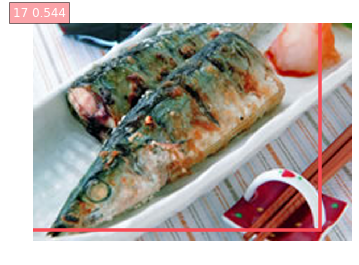

In [0]:
img_path = 'drive/My Drive/MSc dataset/localisation-test/mixed/%s.jpg' % str(index)
predict(rcnn, img_path, 'rcnn')

Shape of pre-processed image: (1, 3, 416, 610)


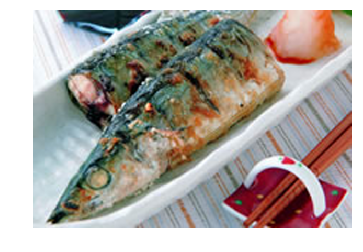

In [0]:
img_path = 'drive/My Drive/MSc dataset/localisation-test/mixed/%s.jpg' % str(index)
predict(yolo, img_path, 'yolo')